# FIXING PHASE IMBALANCES IN AN AWESENSE GRID:
## AN INTEGER PROGRAMMING APPROACH

#### Upload necessary libraries

In [7]:
import getpass
import pandas as pd
import numpy as np
# import matplotlib as mplot
import urllib.parse
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown as md
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
import pytz

# Extra import
import copy
import random
import gurobipy as gp
from gurobipy import GRB
import plotly.io as pio # to display images in Github
from IPython.display import Image

## To install guroby on Python I used "python -m pip install gurobipy"

pd.set_option('display.max_columns', None)

## PART 1: download and prepare the data

#### Connection

In [3]:
# Input creditials by code (need to remove your private info before you pushed it)
# edm_address = ""
# edm_name = ""
# edm_password = ""

# User input the creditials manually 
edm_address = 'sandpit-edm.awesense.com'
edm_name = 'PIMS-Marco'
edm_password = getpass.getpass(prompt='Password: ')

edm_password = urllib.parse.quote(edm_password)

%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False

# Delete the credential variables for security purposes.

del edm_name, edm_password

#### Select parameters

In [4]:
#grid_id = 'awefice'
#grid_element_id = 'transformer_6'

grid_id = 'North Central Zone'
#grid_element_id = '28538_hvmv'
grid_element_id = '12373_hvmv'

#### Create Temporary Views

The third table - “meter_consumption2” is our data table. It is made as a join of the two tables before it (“grid_element_metric” and “meter_data_source2”). “meter_consumption2” gives us data about consumers -  their grid_id, grid_element_id, phase of the element, timestamp, and kWh consumed by the element in this timestamp.
From this table we retrieve the data in the relevant timeframe in the next box.

In [5]:
%%sql 

CREATE OR REPLACE TEMPORARY VIEW grid_element_metric AS
    SELECT grid_id,
            grid_element_id,
            phases,
            type,
            provider,
            direction,
            friendly_id,
            metric_key AS metric,
            valid,
            timestamp,
            value
    FROM grid_element_data_source AS geds
    JOIN UNNEST(geds.metrics::TEXT[]) AS metric_key
        ON true
    LEFT JOIN ts_data_source_select(grid_element_data_source_id, metric_key) AS ts
        ON true;

CREATE OR REPLACE TEMPORARY VIEW meter_data_source2 AS
    SELECT meter.grid_id,
            meter.grid_element_id,
            geds.grid_element_data_source_id,
            geds.friendly_id,
            geds.phases,
            geds.provider,
            metric_key as metric,
            lower(geds.valid) as start_time,
            upper(geds.valid) as end_time
    FROM grid_get_downstream('{grid_id}', '{grid_element_id}') AS meter
    LEFT JOIN grid_element_data_source AS geds
        ON meter.grid_element_id = geds.grid_element_id
        AND meter.grid_id = geds.grid_id
        AND geds.type = 'CONSUMER'
    JOIN UNNEST(geds.metrics::TEXT[]) AS metric_key
        ON true
    WHERE meter.type = 'Meter';

CREATE OR REPLACE TEMPORARY VIEW meter_consumption2 AS
    SELECT meter.grid_id,
           meter.grid_element_id,
           meter.phases,
           timestamp,
           value AS kWh
    FROM meter_data_source2 AS meter
    LEFT JOIN grid_element_metric AS gem
        ON gem.grid_id = meter.grid_id
        AND gem.grid_element_id = meter.grid_element_id
    WHERE gem.metric = 'kWh'
    AND gem.type = 'CONSUMER';

[]

#### Download data

In [6]:
query = """
SELECT grid_element_id, phases, timestamp, kwh
FROM meter_consumption2
WHERE timestamp >= '2023-01-01 00:00:00'
AND timestamp <= '2023-12-31 23:59:59';
"""

# Execute the query using %sql magic command.
result = %sql $query

meter_consumption_2023_df = result.DataFrame()

## Aggregate the data

#### Add a column with the cluster_id

In this section we retrieve all the elements in the grid which h come after our original element. We get their names and phases, and the name of their connectors - terminal1_cn, terminal2_cn for each element. When terminal1_cn
of element B is equal to terminal2_cn of element A, it means that element B comes immediately after element A. terminal1_cn is the name of the “entry” connector, and terminal2_cn is the name of the “exit” connector.
There can be several elements that come immediately after element A (i.e. they all have the same terminal1_cn). Using this we created a “map” of the grid after the original element. In each case where there is a transition from an ABC phase element to a non ABC element, we call the latter “junction”. Each such junction represents a cluster of meters of the same phase.Now we look for all the meters under this junction, and look for their consumption based on timestamps.

In [8]:
element_downstream = %sql SELECT grid_element_id, phases, terminal1_cn, terminal2_cn FROM grid_get_downstream('{grid_id}', '{grid_element_id}')
element_downstream = element_downstream.DataFrame()

#Merging elements that come one following the other
BB = element_downstream.merge(element_downstream, left_on='terminal2_cn', right_on='terminal1_cn',suffixes=('_upper', '_lower'))

#Tracing elements where the phases change from ABC to non-ABC
bif = BB[(BB['phases_upper']=='ABC') & (BB['phases_lower']!='ABC')]

meters_under_junctions = pd.DataFrame(columns=['grid_element_id', 'junction'])

#Finding meters under each junction
for junction in bif['grid_element_id_lower']:
    # Find meters under each junction
    meters_under_junction = %sql SELECT grid_element_id FROM grid_get_downstream('{grid_id}', '{junction}')\
                            WHERE type='Meter';
    #     
    meters_under_junction = meters_under_junction.DataFrame()
    meters_under_junction['junction'] = junction
    #
    meters_under_junctions = pd.concat([meters_under_junctions, meters_under_junction], axis=0)

meter_consumption_2023_df = meter_consumption_2023_df.merge(meters_under_junctions, on='grid_element_id')
print(meter_consumption_2023_df.head())

  grid_element_id phases                 timestamp       kwh   junction
0        17AY10-1      B 2023-01-01 00:00:00+00:00  1.255925  L17-57719
1        17AY10-1      B 2023-01-01 01:00:00+00:00  2.051644  L17-57719
2        17AY10-1      B 2023-01-01 02:00:00+00:00  1.567479  L17-57719
3        17AY10-1      B 2023-01-01 03:00:00+00:00  1.903236  L17-57719
4        17AY10-1      B 2023-01-01 04:00:00+00:00  1.600963  L17-57719


#### Aggregate the clusters

In [9]:
#grouping power consumption each junction
meter_consumption_2023_df = meter_consumption_2023_df.groupby(['junction','phases', 'timestamp']).agg({'kwh': 'sum'}).reset_index()

### Compute average aggregation

In [10]:
average_aggregation = meter_consumption_2023_df.groupby(['timestamp'])['kwh'].sum().reset_index()
average_aggregation = average_aggregation.set_index('timestamp')
average_aggregation = average_aggregation / 3
print(average_aggregation.head())

                                  kwh
timestamp                            
2023-01-01 00:00:00+00:00  263.078478
2023-01-01 01:00:00+00:00  271.221868
2023-01-01 02:00:00+00:00  241.423854
2023-01-01 03:00:00+00:00  264.196307
2023-01-01 04:00:00+00:00  246.188703


#### Plot of the aggregate consumption on the three phases

In [11]:
initial_aggregation = meter_consumption_2023_df.groupby(['phases', 'timestamp'])['kwh'].sum().reset_index()

# Create the figure
fig = go.Figure()

# Add the initial aggregation lines per phase
for phase in initial_aggregation['phases'].unique():
    phase_data = initial_aggregation[initial_aggregation['phases'] == phase]
    fig.add_trace(go.Scatter(x=phase_data['timestamp'], y=phase_data['kwh'], mode='lines', name=f'Phase {phase}'))

# Add the average line
fig.add_trace(go.Scatter(x=average_aggregation.index, y=average_aggregation['kwh'], mode='lines', name='Average', line=dict(dash='dash')))

# Update layout for titles and labels
fig.update_layout(
    title='Aggregate Consumption per Phase over 2023 with Average',
    xaxis_title='Timestamp',
    yaxis_title='kWh',
)

# Save the plot as a static image
fig.write_image("figure_1.png")

# Show the plot
#fig.show()


/Users/marcocaoduro/Documents/GitLab/edm-app-examples/directory/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



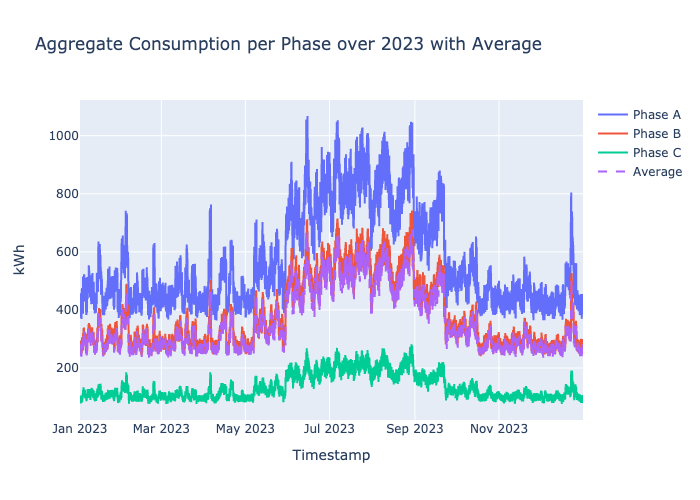

In [12]:
Image("figure_1.png")

#### Compute the initial sum of the imbalances

In [13]:
initial_imbalance= []
# A
initial_A_aggregation = meter_consumption_2023_df[meter_consumption_2023_df['phases'] == 'A'].groupby(['timestamp'])['kwh'].sum().reset_index()
initial_A_aggregation = initial_A_aggregation.set_index('timestamp')
# B
initial_B_aggregation = meter_consumption_2023_df[meter_consumption_2023_df['phases'] == 'B'].groupby(['timestamp'])['kwh'].sum().reset_index()
initial_B_aggregation = initial_B_aggregation.set_index('timestamp')
# C
initial_C_aggregation = meter_consumption_2023_df[meter_consumption_2023_df['phases'] == 'C'].groupby(['timestamp'])['kwh'].sum().reset_index()
initial_C_aggregation = initial_C_aggregation.set_index('timestamp')
#
for t in meter_consumption_2023_df.timestamp.unique():
    dev_A = abs( initial_A_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    dev_B = abs( initial_B_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    dev_C = abs( initial_C_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    max_deviation = max([dev_A, dev_B, dev_C])
    imbalance = max_deviation/ average_aggregation.loc[t].kwh
    initial_imbalance.append([t, imbalance])
initial_imbalance = pd.DataFrame(initial_imbalance, columns = ['timestamp','imbalance'])
initial_imbalance = initial_imbalance.set_index('timestamp')
print( initial_imbalance.head())
initial_sum_of_imbalance = sum(initial_imbalance.imbalance)
print('Sum of the imbalances: ', initial_sum_of_imbalance )

                           imbalance
timestamp                           
2023-01-01 00:00:00+00:00   0.656607
2023-01-01 01:00:00+00:00   0.631054
2023-01-01 02:00:00+00:00   0.607625
2023-01-01 03:00:00+00:00   0.625431
2023-01-01 04:00:00+00:00   0.603919
Sum of the imbalances:  5502.234109722928


#### Create a dictionary of junctions

In [14]:
junctions= {}
for junction_name in meter_consumption_2023_df.junction.unique():
    # Extract the data of a meter
    junc = meter_consumption_2023_df[(meter_consumption_2023_df['junction'] == junction_name)]
    # Identify the current phase of the meter
    current_phase = junc.iloc[0].phases
    # Remove the columns that are not used
    junc = junc[['timestamp', 'kwh']]
    # Set 'timestamp' as the index of the DataFrame
    junc = junc.set_index('timestamp')
    junctions[junction_name] = [junc, current_phase]

## PART 2: Integer Programming Model

#### Define iterators and constant

In [15]:
junctions_id = meter_consumption_2023_df.junction.unique()
times = [t for t in range( len(meter_consumption_2023_df.timestamp.unique()) ) ]
phases = meter_consumption_2023_df.phases.unique()
max_changes = 5


#### Define model and variables

In [16]:
# Create Model
m = gp.Model('Optimize_Over_Year')

# Creare Variables
x = m.addVars(junctions_id, phases, name = 'active_phase_junction', vtype = GRB.BINARY)
change = m.addVars(junctions_id, name = 'is_there_a_change_in_the_junction')
aggregate = m.addVars(times, phases, name = 'aggregate_consumption_per_phase')
max_diff = m.addVars(times, name = 'max_deviation_per_unit_time')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-29


#### Define Easy Constrains

In [17]:
# Create Constraints
# -- Only one phase can be assigned to a junction
one_phase_per_junction = m.addConstrs((gp.quicksum(x[id,p] for p in phases) == 1 for id in junctions_id))
#
# -- Detect change at each meter 
is_junction_changed = m.addConstrs(change[j] == gp.quicksum((1 - int( p == junctions[j][1] ))*x[j,p] for p in phases) for j in junctions_id)
#
# -- Limit the number of possible changes
limit_changes = m.addConstr(gp.quicksum(change[j] for j in junctions_id) <= max_changes)

#### Define "tricky" Constrains

In [18]:
# -- Compute the phase imbalance at each time
aggregate_consumptions = m.addConstrs(aggregate[t, p] == gp.quicksum(x[j,p]*junctions[j][0].iloc[t].kwh for j in junctions_id) for t in times for p in phases)
max_deviation_1 = m.addConstrs(max_diff[t] >=  (aggregate[t, p] - average_aggregation.iloc[t].kwh) for t in times for p in phases)
max_deviation_2 = m.addConstrs(max_diff[t] >= -(aggregate[t, p] - average_aggregation.iloc[t].kwh) for t in times for p in phases)

#### Objective Function

In [19]:
m.setObjective(gp.quicksum(max_diff[t] / average_aggregation.iloc[t].kwh for t in times), GRB.MINIMIZE)

#### Write and solve the IP

In [35]:
# Write LP to check it
m.write("OptimalChanges.lp")

# Let's solve it!
m.optimize()

print('END')

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.0.0 23A344)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 78921 rows, 35200 columns and 1182880 nonzeros
Model fingerprint: 0xb23c3b50
Variable types: 35080 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [4e-01, 6e+02]
  Objective range  [1e-03, 4e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+02]
Presolved: 78881 rows, 35160 columns, 1182800 nonzeros

Continuing optimization...


Cutting planes:
  MIR: 4717

Explored 120 nodes (300801 simplex iterations) in 0.05 seconds (0.14 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 405.886 412.704 443.11 ... 13929.1

Optimal solution found (tolerance 1.00e-04)
Best objective 4.058859201926e+02, best bound 4.058458117033e+02, gap 0.0099%
END


#### Exctract and visualize the solution

List of junctions to change:

In [21]:
# Extract the solution
x_values = pd.Series(m.getAttr("X",x), name = 'phases')
change_values = pd.Series(m.getAttr("X",change), name = 'changes')
IP_changes = []
for j in junctions_id:
    for p in phases:
        val = x_values[j,p]
        if val > 0 and change_values[j] == 1:
            IP_changes.append([j, p])
print(IP_changes)
print(m.ObjVal)

[['L17-140872', 'A'], ['L17-58026', 'C'], ['L17-58058', 'A'], ['L17-58268', 'A'], ['L17-58281', 'C']]
405.88592019261915


Complete list of junctions:

In [22]:
# Extract the solution in the infinty-change setting
x_values = pd.Series(m.getAttr("X",x), name = 'phases')
IP_changes = []
for j in junctions_id:
    for p in phases:
        val = x_values[j,p]
        if val > 0:
            IP_changes.append([j, p])
print(IP_changes)

[['104479', 'A'], ['11628', 'A'], ['118021', 'A'], ['118184', 'A'], ['118861', 'A'], ['14405', 'B'], ['17Y73', 'C'], ['2135', 'C'], ['3956', 'B'], ['47473', 'C'], ['4765', 'B'], ['6598', 'B'], ['7242', 'C'], ['9002', 'B'], ['L17-135884', 'C'], ['L17-136033', 'B'], ['L17-136043', 'C'], ['L17-136188', 'B'], ['L17-136410', 'A'], ['L17-136862', 'C'], ['L17-137270', 'C'], ['L17-137723', 'C'], ['L17-137896', 'C'], ['L17-137897', 'A'], ['L17-138308', 'C'], ['L17-138359', 'A'], ['L17-138713', 'B'], ['L17-139191', 'B'], ['L17-139349', 'C'], ['L17-140870', 'A'], ['L17-140872', 'A'], ['L17-140873', 'C'], ['L17-146892', 'C'], ['L17-57719', 'B'], ['L17-58026', 'C'], ['L17-58058', 'A'], ['L17-58268', 'A'], ['L17-58281', 'C'], ['L17-58341', 'A'], ['L17-84944', 'B']]


# PART 3: Check the improvement

#### Apply changes

Here I save the optimal phase assignment

In [23]:
# Modify Data
new_meter_consumption_2023_df = copy.deepcopy(meter_consumption_2023_df)
for c in IP_changes:
    id_j = c[0]
    phase_j = c[1]
    new_meter_consumption_2023_df.loc[new_meter_consumption_2023_df['junction'] == id_j, 'phases'] = phase_j

#### Check the solution

In [24]:
# Aggregate 
aggregated_consumption = meter_consumption_2023_df.groupby(['phases', 'timestamp'])['kwh'].sum().reset_index()

# Plot graph
fig_before = px.line(aggregated_consumption, x='timestamp', y='kwh', color='phases', title='Aggregated consumption per phase over 2023 - BEFORE changes')

#Aggregate
new_aggregated_consumption = new_meter_consumption_2023_df.groupby(['phases', 'timestamp'])['kwh'].sum().reset_index()

# Plot graph
fig_after = px.line(new_aggregated_consumption, x='timestamp', y='kwh', color='phases', title='Aggregated consumption per phase over 2023 - AFTER changes')

fig_before.write_image("figure_2.png")

fig_after.write_image("figure_3.png")

/Users/marcocaoduro/Documents/GitLab/edm-app-examples/directory/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marcocaoduro/Documents/GitLab/edm-app-examples/directory/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



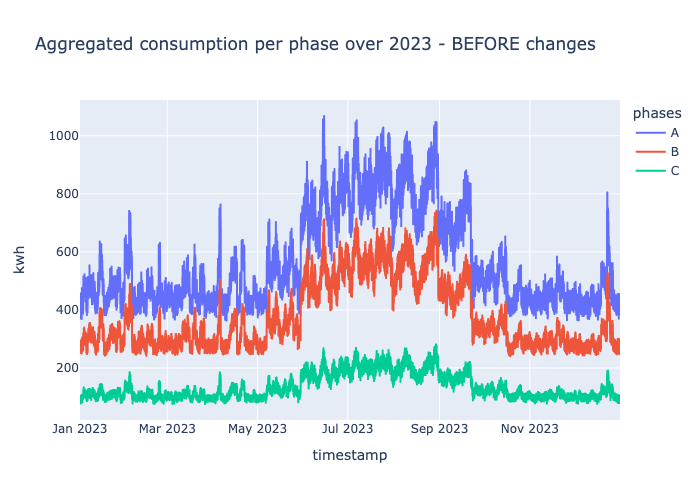

In [27]:
Image("figure_2.png")

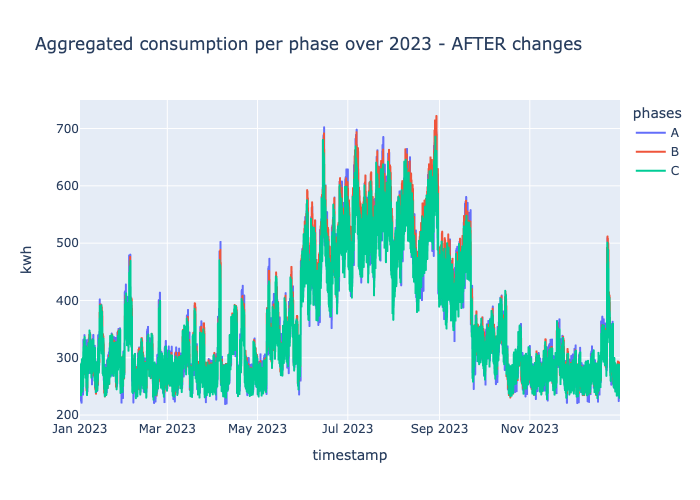

In [26]:
Image("figure_3.png")

#### Compute final imbalance

In [28]:
new_imbalance= []
# A
new_A_aggregation = new_meter_consumption_2023_df[new_meter_consumption_2023_df['phases'] == 'A'].groupby(['timestamp'])['kwh'].sum().reset_index()
new_A_aggregation = new_A_aggregation.set_index('timestamp')
# B
new_B_aggregation = new_meter_consumption_2023_df[new_meter_consumption_2023_df['phases'] == 'B'].groupby(['timestamp'])['kwh'].sum().reset_index()
new_B_aggregation = new_B_aggregation.set_index('timestamp')
# C
new_C_aggregation = new_meter_consumption_2023_df[new_meter_consumption_2023_df['phases'] == 'C'].groupby(['timestamp'])['kwh'].sum().reset_index()
new_C_aggregation = new_C_aggregation.set_index('timestamp')
#
for t in meter_consumption_2023_df.timestamp.unique():
    dev_A = abs( new_A_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    dev_B = abs( new_B_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    dev_C = abs( new_C_aggregation.loc[t].kwh - average_aggregation.loc[t].kwh )
    max_deviation = max([dev_A, dev_B, dev_C])
    imbalance = max_deviation  / average_aggregation.loc[t].kwh
    new_imbalance.append([t, imbalance])
new_imbalance = pd.DataFrame(new_imbalance, columns = ['timestamp','imbalance'])
new_imbalance = new_imbalance.set_index('timestamp')
print( new_imbalance.head())
new_sum_of_imbalance = sum(new_imbalance.imbalance)
print(new_sum_of_imbalance )

                           imbalance
timestamp                           
2023-01-01 00:00:00+00:00   0.081598
2023-01-01 01:00:00+00:00   0.021110
2023-01-01 02:00:00+00:00   0.065959
2023-01-01 03:00:00+00:00   0.080207
2023-01-01 04:00:00+00:00   0.002630
405.8859201926191


#### Plot the imbalance before and after the changes

In [30]:
fig_imb_before = px.line(initial_imbalance.reset_index(), x='timestamp', y='imbalance', title='Plot of the Imbalances - BEFORE changes')
fig_imb_after = px.line(new_imbalance.reset_index(), x='timestamp', y='imbalance', title='Plot of the Imbalances - AFTER changes')

# Change colors# Customize the colors of the scatter plot
for trace in fig_imb_before.data:
    trace.line.color = 'blue'
    trace.name = 'Imbalances before the changes'


# Customize the colors of the line plot
for trace in fig_imb_after.data:
    trace.line.color = 'orange'
    trace.name = 'Imbalances after the changes'

    
fig = go.Figure(data = fig_imb_before.data + fig_imb_after.data)
fig.update_layout(
    title = 'Comparing the imbalances <span style="color:blue"; font-weight:bold>before</span> and <span style="color:orange"; font-weight:bold>after</span>  the changes',
    xaxis_title='timestamp',
    yaxis_title='% of imbalance'
)
fig.write_image("figure_4.png")

/Users/marcocaoduro/Documents/GitLab/edm-app-examples/directory/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/marcocaoduro/Documents/GitLab/edm-app-examples/directory/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:107: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



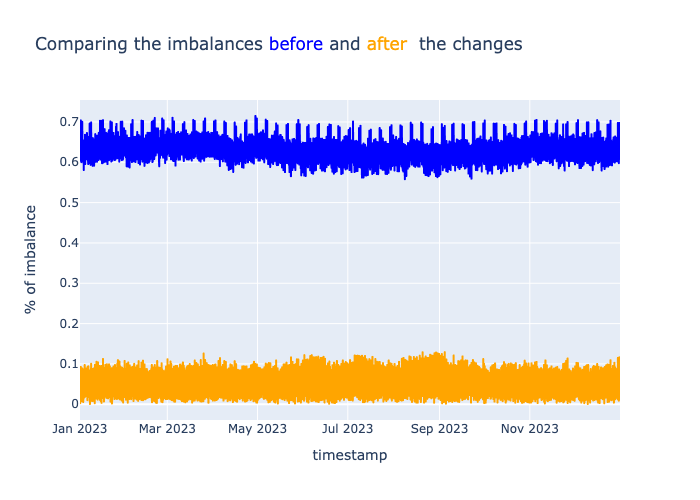

In [31]:
Image("figure_4.png")

### Histogram representation 

In [32]:
tot_aggregation = meter_consumption_2023_df['kwh'].sum()


before_tot_aggregation = meter_consumption_2023_df.groupby(['phases'])['kwh'].sum().reset_index()
before_tot_aggregation['kwh'] = before_tot_aggregation['kwh'] * 100 / tot_aggregation

after_tot_aggregation = new_meter_consumption_2023_df.groupby(['phases'])['kwh'].sum().reset_index()
after_tot_aggregation['kwh'] = after_tot_aggregation['kwh'] * 100 / tot_aggregation


fig_histo_before = px.histogram(before_tot_aggregation, x = 'phases', y = 'kwh', color = 'phases', title = 'Yearly load on phases - BEFORE changes')


fig_histo_after  = px.histogram(after_tot_aggregation, x = 'phases', y = 'kwh', color= 'phases', title = 'Yearly load on phases - AFTER changes')


# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("BEFORE changes", "AFTER changes"))

# Add the first histogram to the first subplot
for trace in fig_histo_before.data:
    fig.add_trace(trace, row=1, col=1)

# Add the second histogram to the second subplot
for trace in fig_histo_after.data:
    fig.add_trace(trace, row=1, col=2)


fig['layout']['yaxis'].update(title_text='% of load')

fig['layout']['yaxis2'].update(title_text='% of load')

# Hide legend for the first subplot
fig.update_traces(showlegend=False, selector=dict(type='histogram'), row=1, col=1)

# Show legend for the second subplot
fig.update_traces(showlegend=True, selector=dict(type='histogram'), row=1, col=2)

# Update layout
fig.update_layout(title_text="Comparison of Yearly Load on Phases", showlegend=True)

# Update x-axis and  y-axis range to go from 0 to 100
fig.update_xaxes(categoryorder='array', categoryarray=['A', 'B', 'C'], row=1, col=1)
fig.update_xaxes(categoryorder='array', categoryarray=['A', 'B', 'C'], row=1, col=2)
fig.update_yaxes(range=[0, 55], row=1, col=1)
fig.update_yaxes(range=[0, 55], row=1, col=2)

# Show the plot
fig.write_image("figure_5.png")

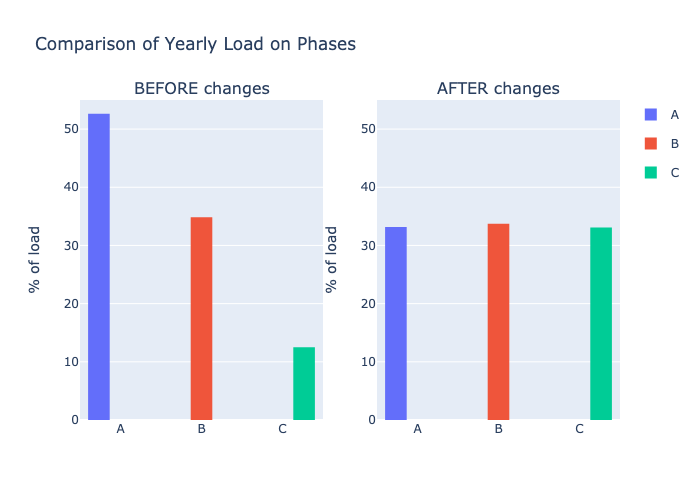

In [33]:
Image("figure_5.png")